In [1]:
from transformers import AutoProcessor
from transformers import AutoModelForCausalLM

from datasets import load_dataset

ds = load_dataset(path="/data/bocheng/huggingface/data/pokemon-blip-captions/")
print(ds)
ds=ds['train'].train_test_split(test_size=0.1)
train_ds=ds['train']
test_ds=ds['test']

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 833
    })
})


# 可视化

In [2]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np

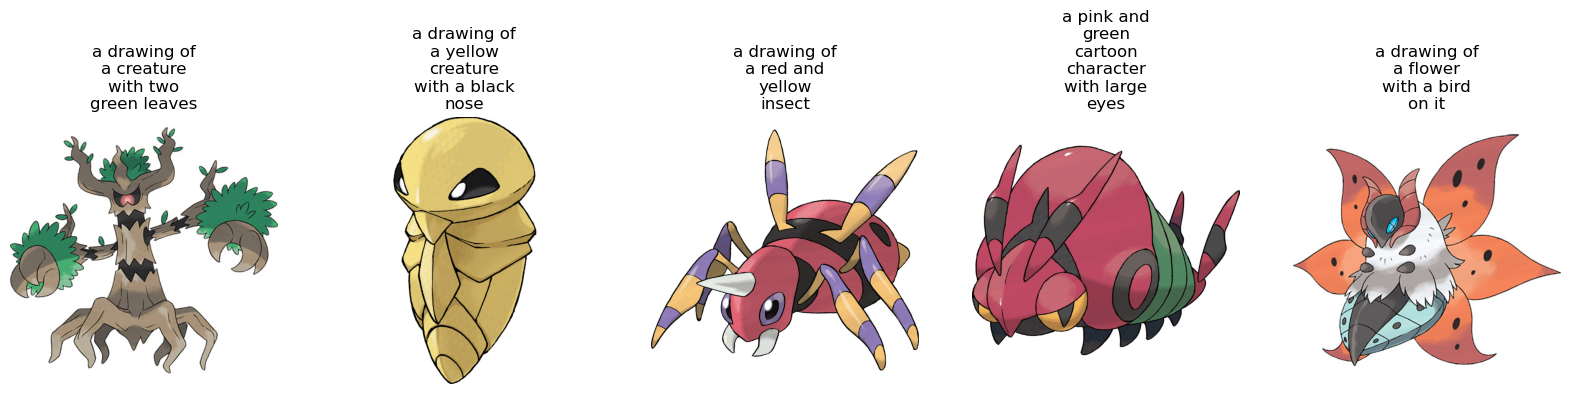

In [4]:
def plot_images(images,captions):
    plt.figure(figsize=(20,20))
    for i in range(len(images)):
        ax=plt.subplot(1,len(images),i+1)
        caption=captions[i]
        caption="\n".join(wrap(caption,12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")
        
sample_images_to_visualize=[np.array(train_ds[i]["image"]) for i in range(5)]
sample_captions=[train_ds[i]['text']for i in range(5)]
plot_images(sample_images_to_visualize,sample_captions)

In [5]:
checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(
    checkpoint, cache_dir="/data/bocheng/huggingface/model/"
)

In [6]:
def transforms(example_batch):
    images=[x for x in example_batch['image']]
    captions=[x for x in example_batch['text']]
    inputs=processor(images=images,text=captions,padding="max_length")
    inputs.update({"labels":inputs['input_ids']})
    return inputs

In [7]:
processor

GitProcessor:
- image_processor: CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "processor_class": "GitProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

- tokenizer: BertTokenizerFast(name_or_path='microsoft/git-base', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False,

In [8]:
train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

In [9]:
model = AutoModelForCausalLM.from_pretrained(
    checkpoint, cache_dir="/data/bocheng/huggingface/model/"
)

In [11]:
from evaluate import load
import torch
wer=load("/data/bocheng/huggingface/evaluate/wer")

In [12]:
def compute_metrics(eval_pred):
    logits,labels=eval_pred
    predicted=logits.argmax(-1)
    decoded_labels=processor.batch_decode(labels,skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

In [21]:
from transformers import TrainingArguments, Trainer

model_name = checkpoint.split("/")[1]

training_args = TrainingArguments(
    output_dir="output-pokemon",
    learning_rate=5e-5,
    num_train_epochs=50,
    fp16=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    save_total_limit=3,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    logging_steps=50,
    remove_unused_columns=False,
    label_names=["labels"],
    load_best_model_at_end=True,
)

In [22]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

In [23]:
trainer.train()

Step,Training Loss,Validation Loss


OutOfMemoryError: CUDA out of memory. Tried to allocate 6.45 GiB (GPU 0; 23.68 GiB total capacity; 11.25 GiB already allocated; 5.76 GiB free; 17.14 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF